In [1]:
import numpy as np
import pandas as pd
import pickle
import os
from copy import deepcopy
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA, KernelPCA
import torch
import torch.nn as nn
import torch.nn.functional as F

import scanpy as sc

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns

import sys
sys.path.insert(0, '/home/deepuser/Desktop/aqib/circuit-state/cpa')

from _utils import gen_modelID, calculate_qc_metrics, get_perts, train_one_epoch, compute_metrics

In [2]:
circuit_markers = ['envZ',
 'ompR',
 'dtpA',
 'ymdF',
 'narU',
 'greB',
 'csgD',
 'zinT',
 'yhdV',
 'csgE',
 'znuA',
 'fecD',
 'ykgO',
 'ykgM',
 'apbE',
 'znuC',
 'mepM',
 'narZ',
 'znuB',
 'yjbE',
 'csgF',
 'fecC',
 'fecE',
 'yjiH',
 'pliG',
 'wcaH',
 'wcaE',
 'narY',
 'wza',
 'wcaG']


In [42]:
plt.rcParams.update({'font.size':23}); plt.rcParams.update({'axes.linewidth':2}); plt.rc('axes', axisbelow=True);
plt.rc('lines',linewidth=3); plt.rcParams['axes.spines.right'] = False; plt.rcParams['axes.spines.top'] = False 
plt.rcParams['xtick.major.size'] = 8; plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.major.width'] = 2; plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.size'] = 8; plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.major.width'] = 2; plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.visible'] = True; plt.rcParams['ytick.minor.visible'] = True; 

strain_palette = [[100/255,190/255,180/255],'tab:blue','tab:red','tab:purple','tab:orange','tab:green','dimgray']


figDir = '/home/deepuser/Desktop/aqib/circuit-state/images/'


In [4]:
# device to train model on
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [5]:
save_model = False

# HYPERPARAMETERS
HIDDEN_DIM = 256     # number of nodes in hidden layers  # NFinal with 256
BASAL_DIM = 5        # latent space dimension
WD_ae =  5.358399410104714e-07          # weight decay for gene encoder, perturbation encoder, and gene decoder regularization
WD_p =  6.834875870077975e-07          # weight decay for perturbation decoder regularization
LR_ae = 2 # 1.6285175512867442           # learning rate for updating gene encoder, perturbation encoder, and gene decoder parameters
LR_p = 2 # 1.18592824486385          # learning rate for updating perturbation decoder parameters
LAM = 0.0001         # discrimination loss maximization during autoencoder updates
BATCH_SIZE = 128     # amt of data pts seen by network per parameter update
GENE_PER = 0.95      # percentile of number of zero expression genes per sample to use as threshold for sample filtering
SAMPLE_PER = 0.05    # percentile of number of samples with zero expression (per gene) to use as threshold for gene filtering

NUM_EPOCHS = 1000 # number of epochs to train for

GENE_PER = 0.95      # percentile of number of zero expression genes per sample to use as threshold for sample filtering
SAMPLE_PER = 0.05    # percentile of number of samples with zero expression (per gene) to use as threshold for gene filtering

In [6]:
# generate unique model ID
# model_id = gen_modelID(path='/home/deepuser/Desktop/aqib/circuit-state/cpa/saved_models')
# print(model_id)

# device to train model on
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# Load data
adata = pickle.load(open('/home/deepuser/Desktop/aqib/circuit-state/NAND_iterate/odata_NANDiterate.pkl','rb')) # log1p'd

# Preprocess data
samples2keep, genes2keep = calculate_qc_metrics(adata.X[:,:-9], within_gene_per=GENE_PER, within_sample_per=SAMPLE_PER)
adata = adata[samples2keep, genes2keep + [True]*9].copy() # [True]*9 is there to keep the synthetic genes

# Convert host gene expression to torch tensor
X = torch.tensor(adata.X[:,0:-9]).type(torch.float) # host gene transcriptomics

# Get pertubation matrix
adata, P = get_perts(adata, time_scale=(0,5), iptg_scale=(0,15), ara_scale=(0,15))
P = torch.tensor(P).type(torch.float)

pert_names = ['Sensor_TetR',
              'Sensor_LacI',
              'Sensor_AraC',
              'Sensor_LuxR',
              'Circuit_PhlF',
              'KanR',
              'CmR',
              'YFP',
              'Circuit_IcaR',
              'time',
              'IPTG',
              'Ara']


cuda:0
within sample cutoff 506.0
Number of samples with high amount of zero genes: 50
within gene cutoff 131.29999999999973
Number of genes with high amount of zeros: 205


In [7]:
class Encoder(nn.Module):
    '''
    Encodes gene expression vectors to latent space of dim hidden_dims[-1]
    '''
    def __init__(self, input_dim, hidden_dims):
        super(Encoder, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.bn = nn.BatchNorm1d(hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[0])
        self.fc3 = nn.Linear(hidden_dims[0], hidden_dims[1])
    
    def forward(self, x):
        x = F.celu(self.bn(self.fc1(x)))
        x = F.celu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    
class Decoder(nn.Module):
    '''
    Decodes gene expression latent vectors back to dim output_dim
    '''
    def __init__(self, output_dim, hidden_dims):
        super(Decoder, self).__init__()
        
        self.fc1 = nn.Linear(hidden_dims[1], hidden_dims[0])
        self.bn = nn.BatchNorm1d(hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[0])
        self.fc3 = nn.Linear(hidden_dims[0], output_dim)
    
    def forward(self, x):
        x = F.celu(self.bn(self.fc1(x)))
        x = F.celu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x
    
    
class PertEncoder(nn.Module):
    '''
    We now want to add in the effect of the perturbations on the basal state. 
    Almost analogous to sDMD, we will do this using a nonlinear function and assume 
    that the perturbation impact is linear in the latent space. 
    '''
    def __init__(self, pert_dim, basal_dim):
        super(PertEncoder, self).__init__()
        
        self.fc1 = nn.Linear(pert_dim, 512) 
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, basal_dim)
        
    def forward(self, x):
        x = F.celu(self.fc1(x))
        x = F.celu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    
class PertDecoder(nn.Module):
    '''
    Map the encoded perturbations back to the original space. This allows us to 
    interpolate in perturbation latent space and then generate new hypotheses. 
    '''
    def __init__(self, pert_dim, basal_dim):
        super(PertDecoder, self).__init__()
        
        self.fc1 = nn.Linear(basal_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, pert_dim)
        
    def forward(self, x):
        x = F.celu(self.fc1(x)) 
        x = F.celu(self.fc2(x))
        x = F.relu(self.fc3(x))  # want positive values
        return x
    
    
class Autoencoder(nn.Module):
    '''
    Gene expression autoencoder + perturbation in latent space. 
    '''
    
    def __init__(self, input_dim, hidden_dims, pert_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dims)
        self.decoder = Decoder(input_dim, hidden_dims)
        self.pertencoder = PertEncoder(pert_dim, hidden_dims[-1])
        
    def forward(self, x, p): # p is the vector of perturbations
        x = self.encoder(x)
        x = x + self.pertencoder(p)
        x = self.decoder(x)
        return x
    
    
class Discriminator(nn.Module):
    '''
    Takes in basal state and uses it to predict the continuous perturbation vector. 
    The goal is to have the discriminator do no better than guessing, meaning that the 
    basal state contains little to no information about the perturbations. 
    '''
    def __init__(self, input_dim, pert_dim):
        super(Discriminator, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, pert_dim)
        
    def forward(self, x):
        x = F.celu(self.fc1(x))
        x = F.celu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x
        

In [8]:
torch.manual_seed(1);

load_model = True
model_id = 'NFinal'

input_dim = X.shape[1]
p_dim = P.shape[1] # perturbation dim

autoenc = Autoencoder(input_dim, [HIDDEN_DIM, BASAL_DIM], p_dim)
discrim = Discriminator(BASAL_DIM, p_dim) # tries to predict each perturbations simultaneously
pertdec = PertDecoder(p_dim, BASAL_DIM) # synthetic gene decoder


if load_model:
    autoenc.load_state_dict(torch.load(
                             '/home/deepuser/Desktop/aqib/circuit-state/cpa/saved_models/autoenc_'+model_id+'.pt'))
    discrim.load_state_dict(torch.load(
                             '/home/deepuser/Desktop/aqib/circuit-state/cpa/saved_models/discrim_'+model_id+'.pt'))
    pertdec.load_state_dict(torch.load(
                             '/home/deepuser/Desktop/aqib/circuit-state/cpa/saved_models/pertdec_'+model_id+'.pt'))
    

autoenc.to(device)
discrim.to(device)
pertdec.to(device)

criterion = nn.MSELoss()

autoenc_optimizer = torch.optim.Adadelta(autoenc.parameters(), lr=LR_ae, weight_decay=WD_ae)
discrim_optimizer = torch.optim.Adam(discrim.parameters(), weight_decay=0.0)
pertdec_optimizer = torch.optim.Adadelta(pertdec.parameters(), lr=LR_p, weight_decay=WD_p)

In [9]:
doTrain = False
if doTrain:
    loss = {'x':[],'d':[],'p':[]}
    for epoch in range(NUM_EPOCHS):

        permutation = torch.randperm(X.shape[0])
        running_loss_x = 0.0
        running_loss_d = 0.0
        running_loss_p = 0.0

        for cnt, jj in enumerate(range(0, X.shape[0], BATCH_SIZE)):

            batch_inds = permutation[jj:jj+BATCH_SIZE] # grab batch 
            batch_x = X[batch_inds].to(device)
            batch_p = P[batch_inds].to(device) 

            # train the discriminator
            discrim_optimizer.zero_grad()

            batch_z = autoenc.encoder(batch_x) # latent x
            p_hat = discrim(batch_z) # prediction of all perts by discriminator
            discrim_loss = criterion(p_hat, batch_p)  
            discrim_loss.backward(retain_graph=True) # retain graph to use the loss as a reward for autoencoder


            # train the autoencoder and pertencoder
            autoenc_optimizer.zero_grad()

            X_hat = autoenc(batch_x, batch_p)
            autoenc_loss = criterion(X_hat, batch_x)  - LAM * discrim_loss 
            autoenc_loss.backward()


            autoenc_optimizer.step()
            discrim_optimizer.step()

            # train the pertdecoder
            pertdec_optimizer.zero_grad()

            p_latent = autoenc.pertencoder(batch_p)
            p_hat = pertdec(p_latent)
            pertdec_loss = criterion(p_hat, batch_p)
            pertdec_loss.backward()
            pertdec_optimizer.step()

            with torch.no_grad():
                running_loss_x += autoenc_loss.item()
                running_loss_d += discrim_loss.item()
                running_loss_p += pertdec_loss.item()

        if epoch % (NUM_EPOCHS*0.1) == 0: 
            loss['x'].append( running_loss_x/(cnt+1) )
            loss['d'].append( running_loss_d/(cnt+1) )
            loss['p'].append( running_loss_p/(cnt+1) )
            print( f'EPOCH: {epoch}, D_LOSS: {running_loss_d/(cnt+1):.4f}, X_LOSS: {running_loss_x/(cnt+1):.4f}, '
                      f'P_LOSS: {running_loss_p/(cnt+1):.4f} ')
            
    with torch.no_grad():
    
        X_hat = autoenc(X.to(device), P.to(device)).cpu().numpy()
        print('x_recon_r2 ',r2_score(X.numpy(),X_hat))
        
        p_hat = pertdec(autoenc.pertencoder(P.to(device))).cpu().numpy()
        print('p_recon_r2 ',r2_score(P.numpy(),p_hat))

        p_hat = discrim(autoenc.encoder(X.to(device))).cpu().numpy()
        print('p_discrim_r2 ',r2_score(P.numpy(),p_hat))


In [10]:
if doTrain:
    plt.plot(np.arange(0,10,1)*1000,loss['x'],label='x_reconstruction')
    plt.plot(np.arange(0,10,1)*1000,loss['d'],label='p_discrimination')
    plt.plot(np.arange(0,10,1)*1000,loss['p'],label='p_reconstruction')
    plt.legend(loc=(1,0.2),frameon=False,fontsize=18)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
if load_model and not doTrain:
    autoenc.eval()
    pertdec.eval()
    discrim.eval()
    with torch.no_grad():

        X_hat = autoenc(X.to(device), P.to(device)).cpu().numpy()
        print('x_recon_r2 ',r2_score(X.numpy(),X_hat))

        p_hat = pertdec(autoenc.pertencoder(P.to(device))).cpu().numpy()
        print('p_recon_r2 ',r2_score(P.numpy(),p_hat))

        p_hat = discrim(autoenc.encoder(X.to(device))).cpu().numpy()
        print('p_discrim_r2 ',r2_score(P.numpy(),p_hat))

x_recon_r2  0.8678692308146863
p_recon_r2  0.9406210900822992
p_discrim_r2  0.4332423265219325


In [11]:
# model_id = 'NFinal2'
# torch.save(autoenc.state_dict(), '/home/deepuser/Desktop/aqib/circuit-state/cpa/saved_models/'+'autoenc_'+model_id+'.pt')
# torch.save(pertdec.state_dict(), '/home/deepuser/Desktop/aqib/circuit-state/cpa/saved_models/'+'pertdec_'+model_id+'.pt')
# torch.save(discrim.state_dict(), '/home/deepuser/Desktop/aqib/circuit-state/cpa/saved_models/'+'discrim_'+model_id+'.pt')

In [12]:
autoenc.eval() 
X_proj = autoenc.encoder(X.to(device)).cpu().detach().numpy()

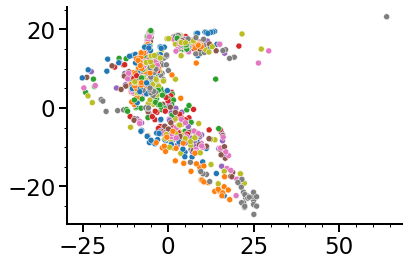

In [13]:
fig, ax = plt.subplots(1,1,figsize=(6,4),sharex=True,sharey=True)
sns.scatterplot(x=X_proj[:,0],y=X_proj[:,1],hue=adata.obs.strain,ax=ax,legend=False)
# plt.xlim(2.75,3.35)
# plt.ylim(0.225,0.3)
plt.show()

In [14]:
def subset_adata(adata,P,strain=['wild-type'],iptg=[0.0],ara=[0.0],time=[0.0]):
    
    strain_bool = adata.obs.strain.isin(strain) # strain to keep 
    iptg_bool = adata.obs.IPTG_concentration.isin(iptg) # iptg to keep
    ara_bool = adata.obs.arabinose_concentration.isin(ara) # ara to keep 
    time_bool = adata.obs.timepoint.isin(time) # time to keep 
    inds = np.nonzero( (strain_bool & iptg_bool & ara_bool & time_bool).values )[0].tolist() # bool of inds to keep
    bdata = adata[inds].copy() # subset adata 
    Pb = P[inds]
#     Pb = np.concatenate(( bdata.X[:,-9:],
#                  bdata.obs.timepoint.values.reshape(-1,1),
#                  bdata.obs.IPTG_concentration.values.reshape(-1,1),
#                  bdata.obs.arabinose_concentration.values.reshape(-1,1) ),axis=1) # get corresponding perts
    
    return bdata, Pb, inds

def infer(autoenc, x, p, device):
    autoenc.eval()
    x_hat = autoenc(x.to(device), p.to(device)).cpu().detach().numpy()
    return x_hat

In [15]:
### Compare NAND to wild-type single synthetic gene counterfactuals
xdata, Px, xinds = subset_adata(adata, P, strain=['NAND_Circuit','landing_pads','PhlF_Gate','IcaR_Gate','pTACmin','pBADmin']
                                ,time=adata.obs.timepoint.unique().tolist()) # exp
cdata, Pc, cinds = subset_adata(adata, P, strain=['wild-type'],time=adata.obs.timepoint.unique().tolist()) # control

# evaluate model predictions for exp and control
X_hat_x = infer(autoenc, X[xinds], Px, device) # experiment    
X_hat_c = infer(autoenc, X[cinds], Pc, device) # control

# INDIVIDUAL INFLUENCES
# calculate the influence of each synthetic gene pert on the host transcriptome using dist as metric
# counterfactually change perts and calculate distance of predictions from exp predictions
cf_dists = np.zeros((X.shape[1],P.shape[1]-3)) # ngenes x nperts (just syn genes)
for ii in range(0, 9): # only adjusting synthetic gene expression (setting individually to zero)
    # counterfactual 
    Px_cf = deepcopy(Px)
    # ind to set to zero
    inds_to_zero = [ii]
    # what fraction of expression to remove
    frac2rmv = 1
    # form counterfactual perturbation tensor
    Px_cf[:,inds_to_zero] = Px_cf[:,inds_to_zero] - frac2rmv * Px_cf[:,inds_to_zero]
    # evaluate model predictions for counterfactual
    X_hat_cf = infer(autoenc, X[xinds], Px_cf, device) 
    cf_dists[:,ii] = np.linalg.norm(X_hat_x - X_hat_cf, axis=0)  

# set dist to zero where the gene was poorly reconstructed in the control setting
c_dist = np.linalg.norm(X_hat_c - X[cinds].numpy(),axis=0)
high_mse_bool = ( c_dist > np.percentile(c_dist,95) )
cf_dists[high_mse_bool,:] = 0.0

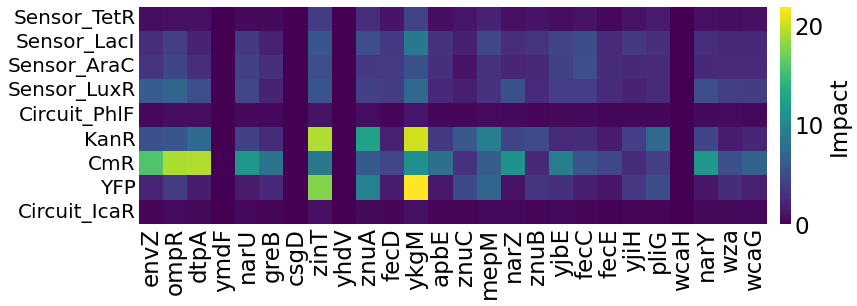

In [16]:
savefig = False

circuit_inds = [adata.var_names.tolist().index(gene) for gene in circuit_markers if gene in adata.var_names]

plt.rcParams['xtick.minor.visible'] = False; plt.rcParams['ytick.minor.visible'] = False; 
plt.rcParams['axes.spines.right'] = True; plt.rcParams['axes.spines.top'] = True; 
plt.rcParams['xtick.major.size'] = 0;
plt.rcParams['ytick.major.size'] = 0;

plt.figure(figsize=(15,4))
sns.heatmap(cf_dists[circuit_inds].T,
            xticklabels=adata.var_names[circuit_inds],
            yticklabels=pert_names[:9],
            cbar_kws={'label':'Impact','pad':0.015},
           cmap='viridis',square=True)
fig = plt.gcf()
# fig.axes[0].set_xticklabels(adata.var_names[circuit_inds],fontsize=22)
fig.axes[0].set_yticklabels(pert_names[:9],fontsize=20)
if savefig: 
    plt.savefig(figDir+'heatmap_synimpact_markers.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

plt.rcParams['xtick.minor.visible'] = True; plt.rcParams['ytick.minor.visible'] = True; 
plt.rcParams['axes.spines.right'] = False; plt.rcParams['axes.spines.top'] = False; 
plt.rcParams['xtick.major.size'] = 8;
plt.rcParams['ytick.major.size'] = 8;

Index(['purE', 'znuB', 'modB', 'aceA', 'znuC', 'tyrA', 'aceB', 'narU', 'ompC',
       'envZ', 'mqsR', 'pliG', 'thrA', 'modA', 'dtpA', 'mepM', 'ompR', 'znuA',
       'zinT', 'ykgM'],
      dtype='object')


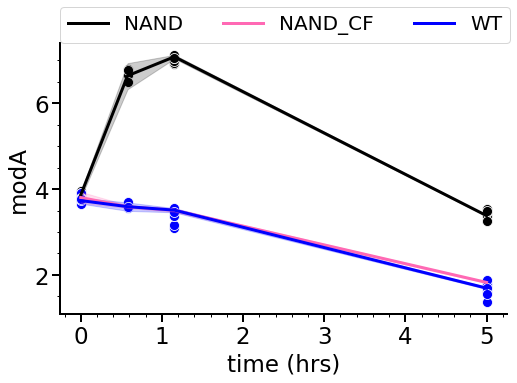

In [17]:
### Compare NAND to wild-type single synthetic gene counterfactuals
xdata, Px, xinds = subset_adata(adata, P, strain=['NAND_Circuit'],time=adata.obs.timepoint.unique().tolist()) # exp
cdata, Pc, cinds = subset_adata(adata, P, strain=['wild-type'],time=adata.obs.timepoint.unique().tolist()) # control

# evaluate model predictions for exp and control
X_hat_x = infer(autoenc, X[xinds], Px, device) # experiment    
X_hat_c = infer(autoenc, X[cinds], Pc, device) # control

# counterfactual 
Px_cf = deepcopy(Px)
# ind to set to zero
# inds_to_zero = [0,1,2,3]
# inds_to_zero = [4,5,6,7,8]
inds_to_zero = [0,1,2,3,4,5,6,7,8]
# what fraction of expression to remove
frac2rmv = 1
# form counterfactual perturbation tensor
Px_cf[:,inds_to_zero] = Px_cf[:,inds_to_zero] - frac2rmv * Px_cf[:,inds_to_zero]
# evaluate model predictions for counterfactual
X_hat_cf = infer(autoenc, X[xinds], Px_cf, device) 
cf_dist = np.linalg.norm(X_hat_x - X_hat_cf, axis=0)    
# set cf_dist to zero where the gene was poorly reconstructed in the control setting
high_mse_bool = (np.linalg.norm(X_hat_c - X[cinds].numpy(),axis=0) > 1.5)
cf_dist[high_mse_bool] = 0.0

print( adata.var_names[:-9][np.argsort(cf_dist)][-20:] )

this_gene = 'modA' # adata.var_names[np.argsort(cf_dist)][-1]
this_ind = adata.var_names.tolist().index(this_gene)
plt.figure(figsize=(8,5))
sns.scatterplot(x = Px[:,-3],
                y = X[xinds,this_ind].numpy(),
                s = 100, legend = False, color='k',)

sns.scatterplot(x = Pc[:,-3],
                y = X[cinds,this_ind].numpy(),
                s = 100, legend = False, color='b',)

sns.lineplot(x=Px[:,-3],
             y=X_hat_x[:,this_ind],
             color='k',label='NAND')

sns.lineplot(x=Px_cf[:,-3],
             y=X_hat_cf[:,this_ind],
             color='hotpink',label='NAND_CF')

sns.lineplot(x=Pc[:,-3],
             y=X_hat_c[:,this_ind],
             color='b',label='WT')

plt.legend(loc=(0,1),ncol=3,fontsize=20)
# plt.ylim(3.5,9.25)
plt.ylabel(this_gene)
plt.xlabel('time (hrs)')
plt.show()

In [18]:
adata.var_names[:-9][np.argsort(cf_dist)][-30:]

Index(['grcA', 'thrC', 'yeeD', 'thrB', 'cysK', 'metF', 'glnK', 'hybO', 'tyrP',
       'mqsA', 'purE', 'znuB', 'modB', 'aceA', 'znuC', 'tyrA', 'aceB', 'narU',
       'ompC', 'envZ', 'mqsR', 'pliG', 'thrA', 'modA', 'dtpA', 'mepM', 'ompR',
       'znuA', 'zinT', 'ykgM'],
      dtype='object')

In [19]:
### Compare wild-type to wild-type IPTG/Ara counterfactuals
xdata, Px, xinds = subset_adata(adata, P, strain=['wild-type'],iptg=[15.0],ara=[0.0],
                                time=adata.obs.timepoint.unique().tolist()) # exp
cdata, Pc, cinds = subset_adata(adata, P, strain=['wild-type'],iptg=[0.0],ara=[0.0],
                                time=adata.obs.timepoint.unique().tolist()) # control

# evaluate model predictions for exp and control
X_hat_x = infer(autoenc, X[xinds], Px, device) # experiment    
X_hat_c = infer(autoenc, X[cinds], Pc, device) # control

# counterfactual for synthetic gene expressions
Px_cf = deepcopy(Px)
# ind to set to zero
inds_to_zero = [-2]
# fraction to remove
frac2rmv = 1
# form counterfactual perturbation tensor
Px_cf[:,inds_to_zero] = Px_cf[:,inds_to_zero] - frac2rmv * Px_cf[:,inds_to_zero]
# evaluate model predictions for counterfactual
X_hat_cf = infer(autoenc, X[xinds], Px_cf, device) 
cf_dist = np.linalg.norm(X_hat_x - X_hat_cf, axis=0)    
# set cf_dist to zero where the gene was poorly reconstructed in the control setting
high_mse_bool = (np.linalg.norm(X_hat_c - X[cinds].numpy(),axis=0) > 1.5)
cf_dist[high_mse_bool] = 0.0

print( adata.var_names[np.argsort(cf_dist)][-20:] )

Index(['araF', 'adiY', 'yecJ', 'envZ', 'yjiX', 'araD', 'ynbE', 'ychQ', 'ompR',
       'ompF', 'galP', 'menH', 'araA', 'rnpA', 'ompC', 'galK', 'galT', 'dtpA',
       'galE', 'araB'],
      dtype='object')


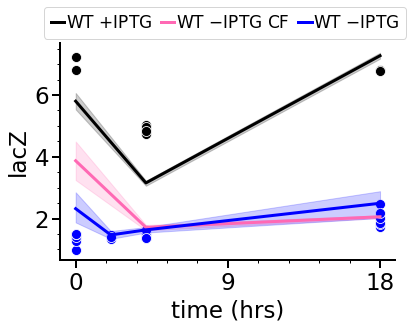

In [20]:
savefig = False
this_gene = 'lacZ' # adata.var_names[np.argsort(cf_dist)][-1]
this_ind = adata.var_names.tolist().index(this_gene)
plt.figure(figsize=(6,4))
sns.scatterplot(x = Px[:,-3],
                y = X[xinds,this_ind].numpy(),
                s = 100, legend = False, color='k',)

sns.scatterplot(x = Pc[:,-3],
                y = X[cinds,this_ind].numpy(),
                s = 100, legend = False, color='b',)

sns.lineplot(x=Px[:,-3],
             y=X_hat_x[:,this_ind],
             color='k',label='WT $+$IPTG')

sns.lineplot(x=Px_cf[:,-3],
             y=X_hat_cf[:,this_ind],
             color='hotpink',label='WT $-$IPTG CF')

sns.lineplot(x=Pc[:,-3],
             y=X_hat_c[:,this_ind],
             color='b',label='WT $-$IPTG')

plt.xticks(ticks=np.linspace(0,5,3),labels=[int(x) for x in np.linspace(0,18,3)])

plt.legend(loc=(-0.05,1.02),ncol=3,fontsize=17,handletextpad=0.1,handlelength=0.8,columnspacing=0.5)
# plt.ylim(3.5,9.25)
plt.ylabel(this_gene)
plt.xlabel('time (hrs)')
if savefig: 
    plt.savefig(figDir+f'line_lacZ_counterfactual.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

In [21]:
### Pertubation embeddings ###
autoenc.eval()
latent_pert = autoenc.pertencoder(P.to(device)).detach().cpu().numpy()

if BASAL_DIM > 2: 
    pca = KernelPCA(n_components=2,kernel='sigmoid',gamma=0.001, degree = 5)
    pca.fit(latent_pert)
    pert_proj = pca.fit_transform(latent_pert)
#     latent_pert_hat = pca.inverse_transform(pert_proj)

In [22]:
strain2num = {strain:ii for ii, strain in enumerate(adata.obs.strain.unique().tolist())}
strainNumList = [strain2num[strain] for strain in adata.obs.strain.tolist()]

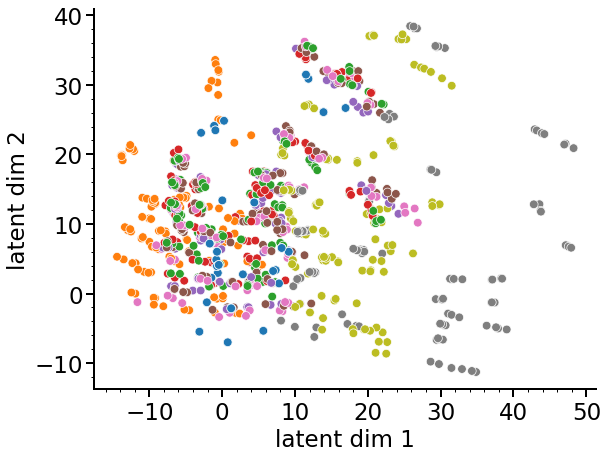

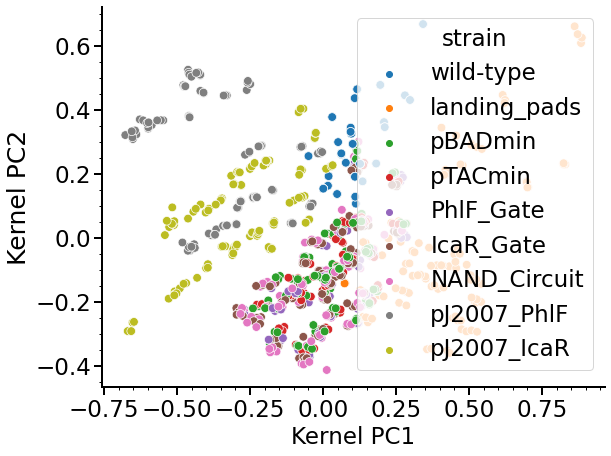

In [23]:
plt.figure(figsize=(9,7))
g = sns.scatterplot(x=latent_pert[:,0],y=latent_pert[:,1],hue=adata.obs.strain,s=75,legend=False)
# sns.scatterplot(x=[-7.75],y=[3.375],color='r',s=125,edgecolor='k',linewidth=2,zorder=-1,alpha=0.4)
plt.xlabel('latent dim 1')
plt.ylabel('latent dim 2')
plt.show()

if BASAL_DIM > 2: 
    plt.figure(figsize=(9,7))
    g = sns.scatterplot(x=pert_proj[:,0],y=pert_proj[:,1],hue=adata.obs.strain,s=75,legend=True)
    plt.xlabel('Kernel PC1')
    plt.ylabel('Kernel PC2',fontsize=25)
    plt.show()
    

### Determine which synthetic perturbations have the most impact on host genes
Calculate gradient of each host gene w.r.t. each synthetic gene, time, and dose (IPTG/Ara)

In [24]:
x = X.requires_grad_()
p = P.requires_grad_()
x_hat = autoenc(x.to(device), p.to(device))

# calculate the derivative of the output, x_hat, w.r.t. pertubations p. 
# need to loop over the genes in x_hat and compute the derivatives separately. 
J = np.zeros((x.shape[0],x.shape[1],p.shape[1]))
for ii in range(J.shape[1]):
    J[:,ii,:] = torch.autograd.grad(outputs = [x_hat[:,ii:ii+1]],
                                    inputs = [p], 
                                    grad_outputs = torch.ones_like(x_hat[:,0:1]),
                                    allow_unused=False,
                                    retain_graph=True, 
                                    create_graph=True)[0].detach().cpu().numpy()

In [26]:
savefig = False

circuit_inds = [adata.var_names.tolist().index(gene) for gene in circuit_markers if gene in adata.var_names]

plt.rcParams['xtick.minor.visible'] = False; plt.rcParams['ytick.minor.visible'] = False; 
plt.rcParams['axes.spines.right'] = True; plt.rcParams['axes.spines.top'] = True; 
plt.rcParams['xtick.major.size'] = 0;
plt.rcParams['ytick.major.size'] = 0;

plt.figure(figsize=(15,4))
sns.heatmap(J[:,circuit_inds].T,
            xticklabels=adata.var_names[circuit_inds],
            yticklabels=pert_names[:9],
            cbar_kws={'label':'Impact','pad':0.015},
           cmap='viridis',square=True)
fig = plt.gcf()
# fig.axes[0].set_xticklabels(adata.var_names[circuit_inds],fontsize=22)
fig.axes[0].set_yticklabels(pert_names[:9],fontsize=20)
if savefig: 
    plt.savefig(figDir+'heatmap_synimpact_markers.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

plt.rcParams['xtick.minor.visible'] = True; plt.rcParams['ytick.minor.visible'] = True; 
plt.rcParams['axes.spines.right'] = False; plt.rcParams['axes.spines.top'] = False; 
plt.rcParams['xtick.major.size'] = 8;
plt.rcParams['ytick.major.size'] = 8;

ValueError: Must pass 2-d input. shape=(12, 26, 957)

<Figure size 1080x288 with 0 Axes>

In [ ]:
savefig = False
n = 12
colors = plt.cm.nipy_spectral(np.linspace(0,1,n))

plt.figure(figsize=(6,4))

gene = adata.var_names.tolist().index('mepM')
for pert_ind in range(len(pert_names)):
    alpha = 0.25 # if (pert_ind != len(pert_names)- 1 ) else 0.85
    sns.kdeplot(J[:,gene,pert_ind], # ~adata.obs.strain.isin(['wild-type']).values
                label=pert_names[pert_ind],
                alpha=alpha,
                color=colors[pert_ind],
               fill=True,edgecolor='dimgray')
#     plt.xlabel(f'influence of {pert_names[pert_ind]}')
# plt.xlim(-5,)
plt.legend(loc=(1.01,-0.22),fontsize=15,ncol=1)
plt.title(adata.var_names[gene],fontsize=23)
plt.xlabel('Influence of perturbations')
if savefig: 
    plt.savefig(figDir+f'hist_{adata.var_names[gene]}_pert_influence.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

In [27]:
impact_dict = {}
for strain in adata.obs.strain.unique().tolist():
    if strain != 'wild-type':
        impact_dict[strain] = {}
        for pert_ind in range(len(pert_names)):
            if pert_ind < 9: # only compute for synthetic genes
                impact_dict[strain][pert_names[pert_ind]] = np.linalg.norm( 
                                                J[adata.obs.strain.isin([strain]).values,:,pert_ind]  )
#             print(strain, np.linalg.norm(J[adata.obs.strain.isin([strain]).values,:,5]))

In [28]:
pd.DataFrame(impact_dict)

,pBADmin,pJ2007_IcaR,landing_pads,PhlF_Gate,pTACmin,NAND_Circuit,pJ2007_PhlF,IcaR_Gate
Sensor_TetR,19.401314,26.946606,17.842578,15.546555,18.563115,15.857886,25.534365,15.741167
Sensor_LacI,29.922903,34.348594,34.868437,34.182414,29.116730,34.552284,21.434158,36.655771
Sensor_AraC,25.325160,19.893792,24.498739,25.978222,24.627409,25.297304,17.349473,26.019841
Sensor_LuxR,48.489837,51.986798,42.861588,44.997011,46.432490,44.508948,41.914672,45.192241
Circuit_PhlF,24.446429,12.045966,34.382717,7.423707,24.553796,7.119369,18.901744,7.642032
KanR,21.995735,13.432254,39.003812,15.722353,21.560711,13.566078,29.105934,16.089934
CmR,22.358272,32.167108,33.693536,15.720077,22.287829,17.317460,37.969484,16.094769
YFP,8.075584,23.182896,42.543553,8.587921,6.607517,8.835041,27.640074,10.089029
Circuit_IcaR,30.032131,16.207027,27.967901,7.418365,29.954680,9.433950,12.195744,10.938576


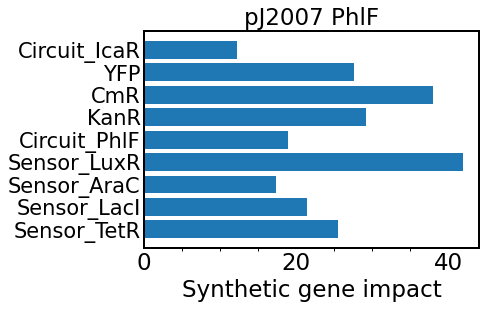

In [29]:
savefig = False
plt.rcParams['xtick.minor.visible'] = True; plt.rcParams['ytick.minor.visible'] = False;
plt.figure(figsize=(6,4))
plt.barh(pert_names[0:9],pd.DataFrame(impact_dict)['pJ2007_PhlF'])
plt.rcParams['xtick.minor.visible'] = True; plt.rcParams['ytick.minor.visible'] = True;
plt.yticks(pert_names[0:9],fontsize=21)
plt.xlabel('Synthetic gene impact')
plt.title('pJ2007 PhlF',fontsize=23)
if savefig: 
    plt.savefig(figDir+'bar_synimpact_pj2007PhlF.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

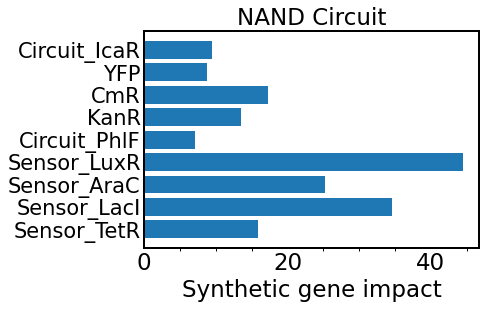

In [30]:
savefig = False
plt.rcParams['xtick.minor.visible'] = True; plt.rcParams['ytick.minor.visible'] = False;
plt.figure(figsize=(6,4))
plt.barh(pert_names[0:9],pd.DataFrame(impact_dict)['NAND_Circuit'])
plt.rcParams['xtick.minor.visible'] = True; plt.rcParams['ytick.minor.visible'] = True;
plt.yticks(pert_names[0:9],fontsize=21)
plt.xlabel('Synthetic gene impact')
plt.title('NAND Circuit',fontsize=23)
if savefig: 
    plt.savefig(figDir+'bar_synimpact_NAND.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

In [31]:
# J_mean = J.mean(axis=0)
# J_std = J.std(axis=0)
# J_influence = J_mean[:,5:6].mean(axis=1)
# sorted_by_influence = np.argsort(J_influence)
# J_sorted = J_mean[sorted_by_influence]
# J_sorted_std = J_std[sorted_by_influence]

# J_max = np.abs(J).max(axis=0)
J_max = np.linalg.norm(J, axis=0)
J_influence = J_max[:,0:9].mean(axis=1)
sorted_by_influence = np.argsort(J_influence)
J_sorted = J_max[sorted_by_influence]

In [32]:
sorted_by_influence[-15:]

array([1685, 2176, 1106, 1237,  257, 1347,  880, 1236,   56,   55, 1261,
         57,  293,  294,  295])

In [33]:
sorted_by_influence.tolist().index(adata.var_names.tolist().index('mepM'))/(adata.n_vars-9)

0.9526992287917738

In [34]:
circuit_inds = [adata.var_names.tolist().index(gene) for gene in circuit_markers if gene in adata.var_names]

In [35]:
x_circuit = [np.argsort(J_influence).tolist().index(x) for x in circuit_inds]

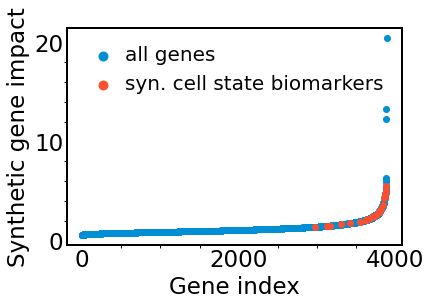

In [36]:
savefig = False
plt.figure(figsize=(6,4))
plt.scatter(np.arange(0,adata.n_vars-9), np.sort(J_influence),label='all genes',color='#008fd5')
plt.scatter(x_circuit, J_influence[circuit_inds],label='syn. cell state biomarkers',color='#fc4f30')
plt.ylabel('Synthetic gene impact')
plt.xlabel('Gene index')
plt.legend(fontsize=20,frameon=False,markerscale=1.5,handletextpad=0.1)
if savefig: 
    plt.savefig(figDir+'scatter_synimpact.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

In [37]:
J_syn = (np.abs(J).sum(axis=0))[:,0:9].sum(axis=1) # don't sum over time, ara, iptg
sorted_inds_J_syn = np.argsort(J_syn)
J_syn_sorted = J_syn[sorted_inds_J_syn]

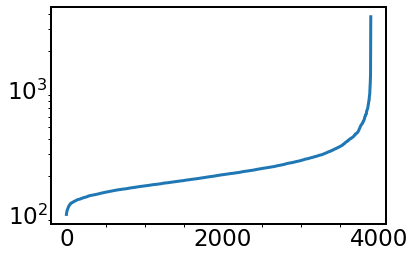

In [38]:
plt.plot(J_syn_sorted)
plt.yscale('log')
plt.show()

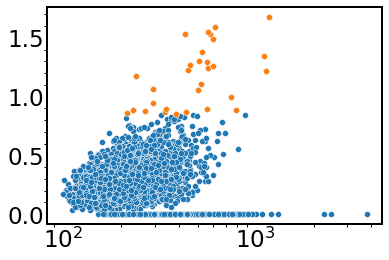

In [39]:
sns.scatterplot(x=J_syn, y=cf_dist)
# sns.scatterplot(x=J_syn[circuit_inds], y=cf_dist[circuit_inds])
sns.scatterplot(x=J_syn[np.argsort(cf_dist)[-30:]], y=cf_dist[np.argsort(cf_dist)[-30:]])
plt.xscale('log')
# plt.yscale('log')

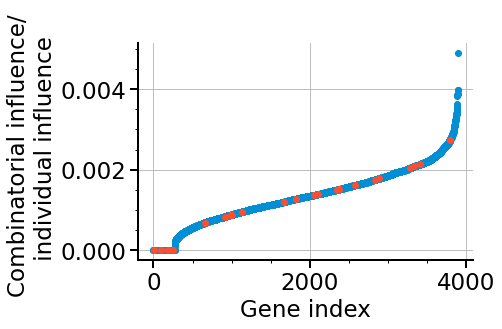

In [43]:
savefig = False
plt.plot(np.sort(cf_dist/J_syn),'o',c='#008fd5')
x_circuit = [np.argsort((cf_dist/J_syn)).tolist().index(x) for x in circuit_inds]
plt.plot(x_circuit,(cf_dist/J_syn)[circuit_inds],'o',color='#fc4f30')
# plt.plot([adata.n_vars-9-30,adata.n_vars-9-30],[0,0.04],'--',lw=1.5,zorder=0,c='k')
# plt.ylim(-0.001,0.04)
# plt.xlim(-100,4000)
plt.grid('on')
plt.xlabel('Gene index');
plt.ylabel('Combinatorial influence/ \n individual influence')
if savefig: 
    plt.savefig(figDir+'scatter_ratioimpact.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

In [41]:
adata.var_names[:-9][np.argsort(cf_dist/J_syn)][-30:]
# remove deaD, purA, ppiD, bsmA, panB, 
# add yjiH, yedE, hybO

Index(['prpC', 'yahI', 'ybhJ', 'pldB', 'grxC', 'ysaA', 'ibaG', 'yfeH', 'yeaL',
       'narX', 'amiA', 'yqiC', 'opgE', 'smtA', 'prmB', 'ygjJ', 'yieK', 'yhfS',
       'ynjF', 'ygcU', 'ubiE', 'galK', 'yecJ', 'dcm', 'yneG', 'panM', 'mobA',
       'yiaK', 'yhaJ', 'yjiX'],
      dtype='object')

Interested in genes which low influence from any one synthetic gene and high influence from the combination of synthetic genes

### Import LSO results

In [16]:
res = pd.read_csv('/home/deepuser/Desktop/aqib/circuit-state/cpa/model_stats/unseen_strain_report.csv',index_col=0)

In [29]:
res_df = res.loc['lso_0007']
res_df.set_index('left_out_strain',inplace=True)
res_df = res_df.loc[['wild-type','landing_pads','pBADmin','pTACmin','PhlF_Gate','IcaR_Gate','NAND_Circuit','pJ2007_PhlF','pJ2007_IcaR']]

In [41]:
strain_palette = [[100/255,190/255,180/255],'tab:blue','tab:red','tab:purple','tab:orange','tab:green','dimgray','y','brown']

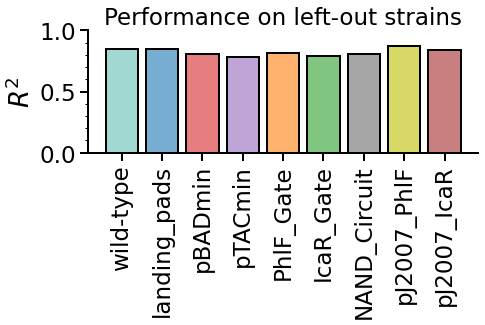

In [72]:
savefig = False
plt.figure(figsize=(7,2.25))
plt.rcParams['xtick.minor.visible'] = False; plt.rcParams['ytick.minor.visible'] = True; 
plt.title('Performance on left-out strains',fontsize=23)
plt.bar(res_df.index.tolist(), res_df['r2_x'].values,
        color=strain_palette,alpha=0.6,edgecolor='k',linewidth=1)
plt.bar(res_df.index.tolist(), res_df['r2_x'].values,
        color='None',alpha=1,edgecolor='k',linewidth=2)
plt.xticks(res_df.index.tolist(),rotation=90)
plt.ylim(0,1)
plt.ylabel(r'$R^2$',fontsize=26)
# plt.grid('on')
if savefig: 
    plt.savefig('/home/deepuser/Desktop/aqib/circuit-state/images/bar_r2_unseen_strains.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()